# An End-to-End Analytic Project Guide
## Using DSS to solve data science questions 

***
What this tutorial covers:

An example of what the Data Science Studio (DSS) framework offers the data scientist. This tutorial is in four parts.  This page is Part 1.

#### Part 1 - Using Python and the Jupyter Notebook
- Spinning up a Spark session
- Pulling data
- Using the DSS datacache and Spark caching
- Exploring the data
- Creating a model
- Getting coefficients and graphs

#### Part 2 - [Modifying the notebook into testable functions](./end-to-end-analytic-project-guide_part2.ipynb)
<span style="color:gray">

- Changing cells into functions
- testing in the notebook
</span>

#### Part 3 - [Creating a recipe and running it in DSS's Airflow environment](./end-to-end-analytic-project-guide_part3.ipynb)
<span style="color:gray">

- Initialize and modify a recipe
- Put code and tests in the right place
- Setting up a recipe taste (metadata, job_request, and the recipe client)
- Creating the job_request and kicking off a run in Airflow
- Checking the run in the Airflow User Interface
- Checking the Spark logs
</span>

#### Part 4 - [Recipe Publishing](./end-to-end-analytic-project-guide_part4.ipynb)
<span style="color:gray">

- Preparing the recipe for publishing
    - testing
    - team review
- Using published recipes
    - running published recipes as a stand-alone recipe
    - running published recipes on a schedule
    - running published recipes as part of another recipe
</span>
    
*** 

# Part 1 - Using Python and the Jupyter Notebook

This guide is intended for data scientists that are new to the Data Science Studio (DSS) platform.  It will move quickly through typical actions that a data scientist might do in an analysis of data.  So when the word "you" is mentioned we are talking about _you_, the data scientist reading this.

The first thing to do is log into Jupyter and bring up a Jupyter session.  If you are reading this in a notebook you are already past this step.  If you are reading this from a PDF on a screen or a printed page you are at a disadvantage and should get onto the platform if possible.  Detailed instructions about logging in are in the tutorial ["Getting Started"](./getting-started.ipynb).  Once you are in you can navigate through the Jupyter interface to the ~/example/tutorials directory where you can click on the `end-to-end-analytic-project-guide.ipynb` file to bring up the interactive version of this page.

This tutorial also assumes you know the basics of developing in a Jupyter notebook.  If this is new to you, you might want to review the first half of the [Jupyter tutorial](./intro-to-jupyter.ipynb).

The code blocks in this tutorial are live and can be executed by you as you read through the tutorial. Just click in the code block and either press the "Run" icon in the page header or press Control-Enter to execute the code in the block. You can change the code and re-execute it if you want to test ideas of how changes will influence the execution or if you want to insert print statements to see values that are being calculated.  Changes to this notebook, or any tutorial notebook, will only be seen in your login server and will only last until your notebook server process is restarted. The restart may occur because you ask for it through the control panel, through more than three days of inactivity, or with the next deployment of the DSS platform.  Deployments are normally scheduled every two weeks. (Other than the `~/example` directory, changes to files under your home directory do not normally go away during a deployment.)  So, if you wish to retain any changes you make, copy this file to a different space under `/home/notebook`.

When you first start up Jupyter you are given a choice of what size notebook you are going to run.  The default is the "Classic" size.  That size is sufficient for the example shown here.  However, if you alter this code to process millions of records, you will want to re-start your server **choosing the "Medium" size notebook** or your notebook's kernel process will die without warning and you will have to go through the process of specifying your notebook size and start up another kernel.

### We get started

After you bring up a blank notebook the first thing you need to do is import the libraries you will be using.  Libraries that start with "dss_" hold code written by the DSS team to make it easier to use the open source tools that are the foundation for the platform. In a notebook running the Python 3 kernel, you will need to set the PYSPARK_PYTHON variable to point to Python 3 prior to connecting to the Spark cluster. This will tell Spark (and pyspark) to use Python 3 for the workers when it spins up worker processes. The code below first checks whether the kernel is Python 2 or Python 3 and sets the environment if needed.

In [1]:
# Set the PYSPARK_PYTHON variable
import os
import sys
if sys.version[0] == '3':
    os.environ['PYSPARK_PYTHON']='/usr/bin/python3'
import textwrap

from dss_datacache_client import client
from dss_airflow_utils.hooks import SparkHook
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

[2019-03-08 20:15:27,660] {settings.py:174} INFO - settings.configure_orm(): Using pool settings. pool_size=5, pool_recycle=1800, pid=374


Next you want to connect to Spark and get a Spark session going.  Running data analysis with Spark dataframes is an easy way to get parallel processes working on your data which has the potential to greatly speed up data analysis.

Here we create a Python function that will be called to set up the variables that control how the Spark session will be configured.  Then we call the SparkHook constructor that will connect to our data source (that's the parameter 'metastore_ndx_uat_adls').  A "hook" is a piece of code that connects a data source with code that reads the data.

After we get the hook we use it to get access to the Spark session object, conventionally named 'spark'.  In this next block of code we end with checking the value of the spark variable.  To do this we take advantage of the Python rule that if you name a variable on the last line and do nothing with it the execution environment prints out a string representation of the value of the variable.

In [2]:
# spark builder function
def builder_func(builder):
    builder.appName('demo_notebook')
    builder.config('spark.dynamicAllocation.maxExecutors', '2')
    builder.config('spark.executor.memory', '2G')
    builder.config('spark.executor.cores', '2')
    builder.config('spark.driver.memory', '2G')
    builder.config('spark.driver.maxResultSize', '2G')
    
    
spark_hook = SparkHook('metastore_ndx_uat_adls', builder_func=builder_func)
spark = spark_hook.get_spark_session()
spark

[2019-03-08 20:15:28,562] {base_hook.py:83} INFO - Using connection to: dssadlsdemocs.azuredatalakestore.net
[2019-03-08 20:15:28,566] {base_hook.py:83} INFO - Using connection to: hiveservice
[2019-03-08 20:15:28,570] {base_hook.py:83} INFO - Using connection to: dssadlsdemocs.azuredatalakestore.net
[2019-03-08 20:15:28,574] {base_hook.py:83} INFO - Using connection to: dssadlsdemocs.azuredatalakestore.net


We first explore the data.  The dates that are in this data set are text strings with more characters than a standard date.  They look like `1 W/E 01/19/19` which stands for "one week, ending on January 19, 2019".  Using SQL functions we can convert this to a standard date type.  Most of the data exploration has been cut out of this notebook, however the following code that determines the date range of the data has been left as an example of date processing.

Code cells like the following, which may take a while to run, have the Jupyter "magic" command %%time.  This command will run the cell's contents and then print out the time that the cell took to run.  The CPU times that are reported are not the total CPU time for spark jobs since spark will distribute the job across multiple executors which Jupyter does not know about.  The Wall time is what is of interest.  Before you run cells with `%%time` in them note how long the previous run took so you have an idea of how long the command may take to run.

In [3]:
%%time

sales_database = 'aod_pg_prototxi_02'

spark.sql("""\
select min(to_date(substring(period_description_short, length(period_description_short)-8, 9), 'MM/dd/yy'))
           as min_date,
       max(to_date(substring(period_description_short, length(period_description_short)-8, 9), 'MM/dd/yy'))
           as max_date
from {0}.fct""".format(sales_database)).show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2018-10-27|2019-01-19|
+----------+----------+

CPU times: user 13 ms, sys: 1.76 ms, total: 14.7 ms
Wall time: 1min 15s


Another hitch that we run into is the difference between Python version 2 and the current Python version 3.  This was a major change in Python that mostly changed the implementation of internal details.  However the change did create some differences between the two versions that have to be covered over with code.  In this case the `date` object in version 3 knows how to efficiently read an ISO standard date formatted string but the `date` in version 2 lacked that capability.  Here is a function that allows us to convert a properly formatted string date into a `date` type regardless of which version of Python is being run.

In [4]:
from datetime import date

def date_fromisoformat(date_str):
    """ Cover difference between Python 2 and Python 3."""
    if sys.version[0] == 3:
        return date.fromisoformat(date_str)
    else:
        return date(*[int(p) for p in date_str.split('-')])

print(date_fromisoformat('2019-01-19').strftime("%B %d, %Y"))

January 19, 2019


Now it is time to pull some data.  The SQL is rather standard but there are places where we can substitute in variables.  The next block starts with the variables that can be substituted and then defines the select statement as a multiline string. The call to textwrap.dedent() removes an equal amount of white space from the start of every line.

At the end of the sql string we have a call to the `str`'s format function.  In this use of `format()` the target string has names whose value is to be replaced enclosed in curly braces.  In the call to `format()` these names are set equal to a variable that holds the replacement value.  

In [5]:
# A query retrieving data from the sales facts database
catg = 'LAUNDRY CARE'
channel = 'Grocery - Supermarket-Conventional'
banner = 'Albertsons'
product_keys = [ 72295087 ] 

# we will pull one product here, but sql below is coded so you could pull more than one
# example of two products
#product_keys = [72295087, 72294873]

Set up our query

In [6]:
sql = textwrap.dedent("""\
select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (fct.dol / fct.units) as act_pri_uni,             /* actual price per unit */
       (fct.Base_DOL / fct.Base_Units) as base_pri_uni,  /* base price per unit */
       case
          when (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)  > 1.0 then 1.0
          else (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)
       end as promo_pri_index  /* in case had problems with round() function */
from {db}.str
inner join {db}.fct
   on fct.pod_id = str.pod_id
inner join {db}.prdc
   on prdc.product_key = fct.product_key
where str.channel like '%{channel}%'
  and str.store_name = '{banner}'
  and str.nielsen_scantrack_mkt_code not like '%NOT APPLICABLE%'
  and prdc.pg_category like '%{category}%'
  and ({products})
  and fct.units > 0
  and fct.dol > 0
  and fct.base_units > 0
  and fct.base_dol > 0
  and (fct.dol / fct.units) > 0.10  /* restrict to reasonable prices */
  ) as a
""").format(db = sales_database,
            channel = channel,
            banner = banner,
            category = catg,
            products = ' OR '.join(["fct.product_key = {}".format(p) for p in product_keys])
           )
print(sql)


select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (fct.dol / fct.units) as act_pri_uni,             /* actual price per unit */
       (fct.Base_DOL / fct.Base_Units) as base_pri_uni,  /* base price per unit */
       case
          when (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)  > 1.0 then 1.0
          else (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)
       end as promo_pri_index  /* in case had problems with round() function */
fro

Now that we have a Spark session and SQL we call the datacache client to go get the data.  The datacache client is a DSS tool that requests the execution of the query and the storing of the result. When the datacache client requests the same query again (as may happen multiple times while developing an analysis) the data query does not have to executed again against Nielsen's database but the results can quickly be read from a file.  The tolerance parameter could say that we want to receive the latest data that is in the cache but if the data are not available in the cache run the query against the upstream database and store the result.  The value that is returned from the call to `get()` is not the data itself, but data about the data (i.e., metadata) that can be used to retrieve the data in a variety of formats.

Note: for the purpose of this tutorial, the query above has already been placed in the datacache to allow for a quick fetch of some data to play with below.  If you change the query and/or tolerance values, re-caching the data could take much longer.

In [7]:
%%time

#CACHE_ONLY = {"type": "range", "to": "latest_cached"}
#meta_data = client.get(query=sql, hook=spark_hook,  tolerance=CACHE_ONLY)
LATEST = {"type": "range", "to": "latest"}
meta_data = client.get(query=sql, hook=spark_hook,  tolerance=LATEST)

[2019-03-08 20:16:54,466] {log.py:114} INFO - f6b97796-0bd1-4eb1-b354-e816bf290061 - TokenRequest:Getting token with client credentials.
[2019-03-08 20:16:54,618] {log.py:114} INFO - f6b97796-0bd1-4eb1-b354-e816bf290061 - OAuth2Client:Get Token Server returned this correlation_id: f6b97796-0bd1-4eb1-b354-e816bf290061
[2019-03-08 20:16:54,755] {api.py:107} INFO - Query select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (fct.dol / fct.units) as act_pri_uni,      

Now we have the metadata from the datacache we ask for the data itself to be returned as a Spark dataframe.  A Spark dataframe is spread across the nodes in a Spark cluster and tries to cache itself in memory for fastest execution.  If there is not enough memory available it will spill to a disk local to the node that the Spark worker is located on.  This makes queries and analysis of large datasets happen in parallel with the highest possible speed.

In [8]:
sdf = meta_data.to_spark(spark)

[2019-03-08 20:16:54,766] {datacache_client.py:159} INFO - Converting adl://dssadlsdemo.azuredatalakestore.net/root/datacache/pandg/5d13b9b134a903d3cd77f333fe2188946e36cd18/1/data path to spark DataFrame


Underlying a Spark DataFrame is the Spark representation of the data, in a set of structures called the Resilient Distributed Dataset, or RDD.  Spark will manage the resources of your cluster to hold in memory the data it believes are most likely to be referenced.  If a DataFrame or RDD is going to be used multiple times, you can give Spark a hint to keep those data around by calling the cache() function.

You should `cache()` RDDs and DataFrames in the following cases:
-    You reuse them in an iterative loop (i.e., ML algorithms)
-    You reuse the RDD or DataFrame multiple times in a single application, job, or notebook. (the case here)
-    When the upfront cost to regenerate the RDD or DataFrame is costly (i.e., after a complex set of map(), filter(), etc.). This helps in the recovery process if a Worker node dies.

In the next cell we cache in Spark the dataframe we got back from the datacache and then run a simple action on it, figuring out how many rows are present.  Up until this step where the rows are counted Spark has not actually created the Spark dataframe, it has just been constructing an execution plan.  Now we actually read the data from the datacache, create the dataframe in memory, and mark it so it will not be discarded and then count the rows.

In [9]:
%%time

# cache so that we can save the materialized dataset for fast reuse
sdf.cache()
print(sdf.count())

452
CPU times: user 2.82 ms, sys: 998 µs, total: 3.82 ms
Wall time: 3.58 s


We can also ask Spark to `show()` the dataframe so as to get a feel for what data are present.  The default for `show()` is 20 rows; below we will request just 5. We can also ask for the column names that are present with the `printSchema()` command. The names are the same as the column name synonymns from the SQL.

In [10]:
%%time

sdf.select(['Scantrack_Code', 'Scantrack_Market', 'Banner', 'pod_id', 'period', 
            'product_key', 'units', 'dol', 'act_pri_uni']).show(5, truncate=15)
sdf.select(['Scantrack_Code', 'pod_id', 'period', 
            'base_units', 'base_dol', 'base_pri_uni', 'promo_pri_index', 'tpr']).show(5, truncate=15)



sdf.printSchema()

+--------------+----------------+----------+-------+----------+-----------+-----+-----+---------------+
|Scantrack_Code|Scantrack_Market|    Banner| pod_id|    period|product_key|units|  dol|    act_pri_uni|
+--------------+----------------+----------+-------+----------+-----------+-----+-----+---------------+
|            42| Salt Lake Ci...|Albertsons| 234134|2018-11-17|   72295087|  1.0| 5.39|           5.39|
|            42| Salt Lake Ci...|Albertsons|  43911|2018-10-27|   72295087|  1.0| 5.99|           5.99|
|            42| Salt Lake Ci...|Albertsons|  10017|2018-11-17|   72295087|  3.0|16.17|5.3900000000...|
|            42| Salt Lake Ci...|Albertsons| 181332|2018-11-03|   72295087|  8.0| 24.0|            3.0|
|            36|         Phoenix|Albertsons|5037047|2018-11-03|   72295087| 11.0|38.17|           3.47|
+--------------+----------------+----------+-------+----------+-----------+-----+-----+---------------+
only showing top 5 rows

+--------------+-------+----------+----

Most of the manipulations that can be done to a Spark dataframe are in the pyspark.sql.functions package.  To make access to these functions easier we import the package and specify a short name as an alias.  We don't actually end up retaining any of the cells that use these functions directly however.  This is part of the development process when doing data analysis in a notebook: you try out a lot of things in cells, find out things about your data, follow the insights and then the hunches don't work out so you delete the notebook cells.

In [11]:
import pyspark.sql.functions as F

So let's create some potentially useful variables for our analysis.  We do that using Spark SQL.  First we tell Spark that the data in the dataframe is to be considered a table named 'tbl' and then we issue a `select ... from tbl`.  When you run this cell it will run quickly.  Why?  Because at this step, Spark merely sets up the pipeline to do the computations.  Until we ask for the actual numbers no final results are computed. 

In [12]:
# create new variables for modeling

sdf.registerTempTable('tbl')

# log our units and price variables 
# compute interaction variable
# also drop outliers we identified in exploratory analyses (not shown here)
nsdf0 = spark.sql("""
  select *,
    log(units) as ln_units,
    log(act_pri_uni) as ln_price,
    log(base_pri_uni) as ln_base_price,
    log(promo_pri_index) as ln_ppi,
    log(act_pri_uni) * tpr as ln_price_tpr
  from tbl
  where act_pri_uni >= 2.25 /* one record at 99 cents, one at $2.23, rest $3.00+ */
    and units < 95          /* one very high outlier */
""")
nsdf0.createOrReplaceTempView('nsdf_v')

We will also mean-center the variables, within store.  This is so we can allow for store-to-store differences without having to include individual intercept terms for each store.

In [13]:
# mean-center by store

# compute the means
sql = textwrap.dedent("""\
select pod_id,
       mean(ln_units)      as avg_ln_units,
       mean(ln_price)      as avg_ln_price,
       mean(ln_base_price) as avg_ln_base_price,
       mean(ln_ppi)        as avg_ln_ppi,
       mean(tpr)           as avg_tpr,
       mean(ln_price_tpr)  as avg_ln_price_tpr
       from nsdf_v 
       group by pod_id
""")
nsdf_means = spark.sql(sql)
nsdf_means.createOrReplaceTempView('nsdf_means_v')

# subtract the means
sql = textwrap.dedent("""\
select a.Scantrack_Code, a.Scantrack_Market, a.Banner, a.pod_id, a.period, 
       a.product_key,
       a.units, a.dol, a.base_units, a.base_dol, 
       a.act_pri_uni, a.base_pri_uni,
       a.promo_pri_index, a.tpr,
       (a.ln_units - b.avg_ln_units) as ln_units_c,
       (a.ln_price - b.avg_ln_price) as ln_price_c,
       (a.ln_base_price - b.avg_ln_base_price) as ln_base_price_c,
       (a.ln_ppi - b.avg_ln_ppi) as ln_ppi_c,
       (a.tpr - b.avg_tpr) as tpr_c,
       (a.ln_price_tpr - b.avg_ln_price_tpr) as ln_price_tpr_c
from nsdf_v as a
left join nsdf_means_v as b
   on b.pod_id = a.pod_id
""")

nsdf = spark.sql(sql)

Now we ask for the pipeline defined in the previous cell to be computed.  The results are available in the variable nsdf (new Spark dataframe).  We call `describe()` on these to see what the variables look like.

In [14]:
%%time

cols = ['ln_units_c',
        'ln_price_c',
        'tpr_c',
        'ln_price_tpr_c'
       ]
nsdf.describe(cols).show(truncate=15)

+-------+---------------+---------------+---------------+---------------+
|summary|     ln_units_c|     ln_price_c|          tpr_c| ln_price_tpr_c|
+-------+---------------+---------------+---------------+---------------+
|  count|            449|            449|            449|            449|
|   mean|8.9015654535...|3.0166416259...|-1.483594242...|-2.967188484...|
| stddev|0.5812014607...|0.1415157067...|0.2872352100189|0.3761125002...|
|    min|-1.451247152...|-0.614751983...|          -0.75|-1.066049258...|
|    max|1.7814431500...|0.3276320299...|0.9230769230...|1.4484941211...|
+-------+---------------+---------------+---------------+---------------+

CPU times: user 4.62 ms, sys: 1.63 ms, total: 6.25 ms
Wall time: 12.4 s


Now to create a model on these data. For illustration, we will fit a linear regression model, regressing the natural log of units sold on the log of price and other variables.

First, we will create vectors to pass to the modeling step.

In [15]:
my_predictors = ['ln_price_c', 'tpr_c', 'ln_price_tpr_c']

from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = my_predictors, outputCol = 'features')
va_nsdf = vectorAssembler.transform(nsdf)
va_nsdf = va_nsdf.select(['ln_units_c', 'features', 'pod_id', 'period', 'tpr', 'Scantrack_Market'])
va_nsdf['ln_units_c', 'features', 'pod_id', 'period', 'tpr'].show(3, truncate=50)
  
    # we aren't including Scantrack_Market in show() simply to keep output from wrapping here

+-------------------+--------------------------------------------------+------+----------+---+
|         ln_units_c|                                          features|pod_id|    period|tpr|
+-------------------+--------------------------------------------------+------+----------+---+
|-0.2772588722239781|  [-0.02652702944502705,-0.1,-0.16094379124341002]|234134|2018-11-17|  0|
|-0.5849063660317286|[0.07672713990584112,-0.14285714285714285,-0.15...| 43911|2018-10-27|  0|
|0.21552985481432907|[0.011790773323581138,-0.07692307692307693,-0.0...| 10017|2018-11-17|  0|
+-------------------+--------------------------------------------------+------+----------+---+
only showing top 3 rows



List the first three rows of our data frame, to show they match the vector representation above.

In [16]:
vars = ['ln_units_c'] + my_predictors + ['pod_id', 'period', 'tpr']
nsdf[vars].show(3, truncate=10)

+----------+----------+----------+--------------+------+----------+---+
|ln_units_c|ln_price_c|     tpr_c|ln_price_tpr_c|pod_id|    period|tpr|
+----------+----------+----------+--------------+------+----------+---+
|-0.2772...|-0.0265...|      -0.1|    -0.1609...|234134|2018-11-17|  0|
|-0.5849...|0.07672...|-0.1428...|    -0.1569...| 43911|2018-10-27|  0|
|0.21552...|0.01179...|-0.0769...|    -0.0916...| 10017|2018-11-17|  0|
+----------+----------+----------+--------------+------+----------+---+
only showing top 3 rows



Now, we'll fit the model.

In [17]:
%%time

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features',
                      labelCol='ln_units_c', 
                      maxIter=150, 
                      regParam=0.0, 
                      elasticNetParam=0.0,
                      fitIntercept=True
                     )
lr_model = lr.fit(va_nsdf)

CPU times: user 34.7 ms, sys: 606 µs, total: 35.3 ms
Wall time: 11.6 s


Examine some measures of goodness-of-fit.

In [18]:
print("RMSE: %f" % lr_model.summary.rootMeanSquaredError)
print("R-squared: %f" % lr_model.summary.r2)

RMSE: 0.516973
R-squared: 0.207040


Now that we have a model pull the coefficients from it.

In [19]:
print("Coefficients for ", my_predictors)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

('Coefficients for ', ['ln_price_c', 'tpr_c', 'ln_price_tpr_c'])
Coefficients: [-0.7603770848967343,1.426857568831969,-0.6743681858864529]
Intercept: 2.05710522735e-17


Now let us look at how well our model fit and how our data match our predictions.  Numpy and Pandas and Matplotlib work nicely together with the Jupyter notebook.  You don't have to download these and install them, they are already loaded within your DSS notebook environment.

In [20]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We need to convert the Spark dataframe into a Pandas dataframe to interact with the matplotlib plotting package.  Pandas has a utility for creating a Pandas dataframe from a Spark dataframe.  Note, however, this utility will pull together all of the information in each of the Spark cluster's "worker nodes."  If the size of your data frame in Spark is very large, this step could cause you to run out of memory in your notebook and the notebook will freeze.  (This will not be the case for our example here.)

In [21]:
# pull out predicted and observed outcome values and other variables, merge with residuals

p = lr_model.summary.predictions['ln_units_c', 'prediction', 'pod_id', 'period', 'tpr', 'Scantrack_Market'].toPandas()
p.rename(columns={'prediction':'predicted'}, inplace=True)

r = lr_model.summary.residuals.toPandas()
r.rename(columns={'residuals':'resid'}, inplace=True)

p_df = pd.concat([p, r], axis=1)

del(p, r)

In [22]:
# split out the "features" column of DenseVectors to merge these predictors with data frame above

lr_model.summary.predictions.createOrReplaceTempView('p')

t = (spark.sql("select features from p").rdd
     .map(lambda x:[float(y) for y in x['features']])
     .toDF(my_predictors)).toPandas()

# merge back in with y, y-hat, and resid
p_df = pd.concat([p_df, t], axis=1)

del(t)

Create a scatter plot of the residuals versus the predicted values.  The plot will appear within the notebook.  Note that the `%%time` function times only the server time it takes to generate the plot instructions.  It can take significantly longer for the generation of the image file if there are many, many points and that time would not be captured by `%%time`.

449 Observations used in the model
CPU times: user 11.6 ms, sys: 70.3 ms, total: 81.9 ms
Wall time: 88.6 ms


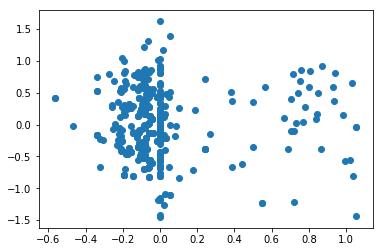

In [23]:
%%time 
print("{0} Observations used in the model".format(p_df.shape[0]))
plt.scatter(p_df.predicted, p_df.resid)  # syntax is plt.scatter(x, y)


Now, let's examine our raw data and our fitted model by whether or not there was a temporary price reduction.

In [24]:
# separate our results by TPR indicator
p_df0 = p_df.loc[p_df['tpr']==0, :]
p_df1 = p_df.loc[p_df['tpr']==1, :]

No Temporary Price Reduction


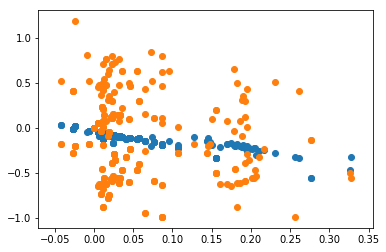

In [25]:
print('No Temporary Price Reduction')
plt.scatter(p_df0.ln_price_c, p_df0.predicted)
plt.scatter(p_df0.ln_price_c, p_df0.ln_units_c)


With Temporary Price Reduction


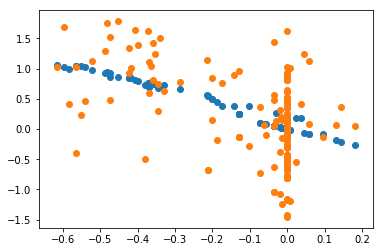

In [26]:
print('With Temporary Price Reduction')
plt.scatter(p_df1.ln_price_c, p_df1.predicted)
plt.scatter(p_df1.ln_price_c, p_df1.ln_units_c)

<span style="color:red">**VERY IMPORTANT**</span>
Stop the Spark session that you started from the notebook.  If you don't do this it continues to live and reserve resources that the cloud provider bills for and that are not available for others to use.

In [27]:
spark.stop()

Now we have a model that we can make available for others to use to analyze other data extracts.  The [next part](./end-to-end-analytic-project-guide_part2.ipynb) of this _Analytic Project_ guide will talk about the process of creating functions that we will eventually put into a DSS "recipe" that can be published for other analysts to use.